<img src='./img/header_placeholder.png' alt='Logo EU Copernicus ECMWF' align='right' width='100%'></img>

<br>

# CAMS Fire monitoring

### About

This notebook provides you a practical introduction to the topic of how to compute climatologies and anomalies on different spatial and temporal levels.

The notebook has the following outline:

* [1 - Unzip the downloaded data file](#unzip_fire)
* [2 - Load and browse CAMS global atmospheric composition forecast of Organic Matter Aerosol Optical Depth at 550nm](#load_fire)
* [3 - Visualize the forecast of Organic Matter AOD at 550nm](#visualize_fire)
* [4 - Animate daily 6-hourly Organic Matter AOD at 550nm forecast over the USA from 1 to 8 August 2021](#animate_fire)

### Data

This notebook introduces you to the [CAMS global atmospheric forecasts](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts?tab=overview). The data has the following specifications:

> **Data**: `CAMS global atmospheric forecasts` <br>
> **Temporal coverage**: `6-hourly forecasts for the period from 1 to 8 August 2021` <br>
> **Spatial coverage**: `Geographic subset of the USA` <br>
> **Format**: `zipped NetCDF`<br>
> **Retrieve request**: [CDS API request](./200_atmosphere_data_store_intro.ipynb#era5_monthly)

Get [here](./201_cams_data_intro.ipynb) more information about CAMS data in general.

### How to access the notebook
* via [nbviewer](https://github.com/ecmwf-projects/copernicus-training/blob/master/111_c3s_climatologies_anomalies.ipynb): view a static version of the notebook 
* via [Binder](https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training/HEAD?urlpath=lab/tree/111_c3s_climatologies_anomalies.ipynb): run, execute and modify the notebook

### Further resources

* [New decade brings reference period change for climate data](https://climate.copernicus.eu/new-decade-reference-period-change-climate-data)
* [2020 closes a decade of exceptional heat](https://public.wmo.int/en/media/news/2020-closes-decade-of-exceptional-heat)
* [Copernicus: 2020 warmest year on record for Europe; globally, 2020 ties with 2016 for warmest year recorded](https://climate.copernicus.eu/2020-warmest-year-record-europe-globally-2020-ties-2016-warmest-year-recorded)

<br>

<hr>

### Load libraries

In [16]:
# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import time

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

from IPython.display import clear_output
clear_output(wait=True)

<hr>

### <a id='unzip_fire'></a> 1. Unzip the downloaded data file

CAMS global atmospheric composition forecasts can be retrieved either in `GRIB` or in a `zipped NetCDF`. Above, we requested the data in a zipped NetCDF and for this reason, we have to unzip the file before we can open it. You can unzip `zip archives` in Python with the Python package `zipfile` and the function `extractall()`.

In [4]:
import zipfile
with zipfile.ZipFile('./data/cams/2021-08_NAmerica_organicMatterAOD.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/cams/202108/')

<br>

### <a id='load_fire'></a> 2. Load and browse CAMS global atmospheric composition forecast of Organic Matter Aerosol Optical Depth at 550nm

Once the data has been extracted from the zip archive, you can load the NetCDF file with the Python library [xarray](http://xarray.pydata.org/en/stable/) and the function `open_dataset()`. The function loads a `xarray.Dataset`, which is a collection of one or more data variables that share the same dimensions. You see that the data files has three dimensions, `latitude`, `longitude` and `time` and one variable, `omaod550`. 

In [19]:
ds = xr.open_dataset('./data/cams/202108/data.nc')
ds

<xarray.Dataset>
Dimensions:    (latitude: 138, longitude: 251, time: 32)
Coordinates:
  * longitude  (longitude) float32 -150.0 -149.6 -149.2 ... -50.8 -50.4 -50.0
  * latitude   (latitude) float32 79.8 79.4 79.0 78.6 ... 26.2 25.8 25.4 25.0
  * time       (time) datetime64[ns] 2021-08-01 ... 2021-08-08T18:00:00
Data variables:
    omaod550   (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-08-16 16:14:32 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

Let us now extract from the Dataset above the data variable `aod550` as `xarray.DataArray`. You can load a data array from a xarray.Dataset by specifying the name of the variable (`aod550`) in square brackets.
While an xarray **dataset** may contain multiple variables, an xarray **data array** holds a single multi-dimensional variable and its coordinates.

In [9]:
omaod550 = ds['omaod550']
omaod550

<xarray.DataArray 'omaod550' (time: 32, latitude: 138, longitude: 251)>
[1108416 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -150.0 -149.6 -149.2 ... -50.8 -50.4 -50.0
  * latitude   (latitude) float32 79.8 79.4 79.0 78.6 ... 26.2 25.8 25.4 25.0
  * time       (time) datetime64[ns] 2021-08-01 ... 2021-08-08T18:00:00
Attributes:
    units:      ~
    long_name:  Organic Matter Aerosol Optical Depth at 550nm

<br>

In [7]:
omaod550_unit = omaod550.units
omaod550_long_name = omaod550.long_name

<br>

### <a id='visualize_fire'></a>3. Visualize the forecast of Organic Matter AOD at 550nm

### <a id='animate_fire'></a>4. Animate daily 6-hourly Organic Matter AOD at 550nm forecast over the USA from 1 to 8 August 2021

To visualise this data we will create an animation, with each frame corresponding to a time step. These include forecasts for each day at lead times of 0, 6, 12 and 18 hours.

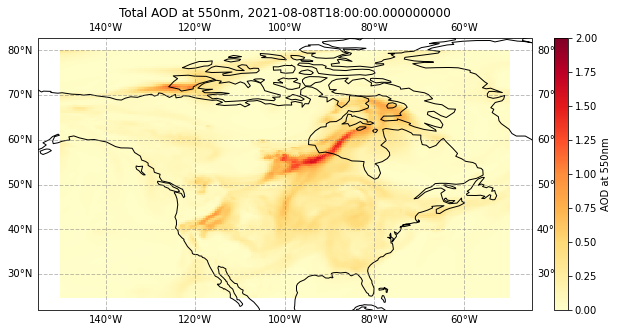

In [18]:
n = omaod550.time.shape[0] # Number of frames in animation (= number of time-steps)

for i in range(n):
    fig = plt.figure(figsize=(10, 5)) # Define the figure and specify size
    ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree()) # Specify plot area & projectionax.set_extent([-150,-50,25,80], crs=ccrs.PlateCarree()) # Specify geographical extent
    
    ax.coastlines(color='black') # Add coastlines
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') # Add lat/lon grid
    ax.set_title(f'Total AOD at 550nm, {omaod550.time[i].values}', fontsize=12) # Set figure title
    
    im = plt.pcolormesh(omaod550.longitude, omaod550.latitude, omaod550[i,:,:], cmap='YlOrRd', vmin=0, vmax=2) # Plot the data, iterating over time
    cbar = plt.colorbar(im,fraction=0.046, pad=0.04) # Specify the colourbar
    cbar.set_label('AOD at 550nm') # Define the colourbar label
    plt.show() # Display the figure
    time.sleep(0.01) # Specify time delay for each iteration (frame) of the animation
    clear_output(wait=True) # Clear the output (figure) before the next iteration (frame) of the animation

The animation clearly shows the high values of organic matter aerosol optical depth originating from the many different wildfires burning across North America in this period. This includes the Dixie fire, which, by August 6, had grown to become the largest single (i.e. non-complex) wildfire in California's history, and the second-largest wildfire overall. 

The animation also shows these high values crossing the continent to the east coast where it still affects local air quality.

<br>

<hr>

<p><img src='./img/copernicus_logo.png' align='right' alt='Logo EU Copernicus' width='20%'></img></p>
<br><br><br><br><br>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>